In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")


In [20]:
df = pd.read_csv("HR_comma_sep.csv")
df.head()


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [21]:
print(df.shape)
print(df.info())
df.isnull().sum()


(14999, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None


satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

Correlation heatmap

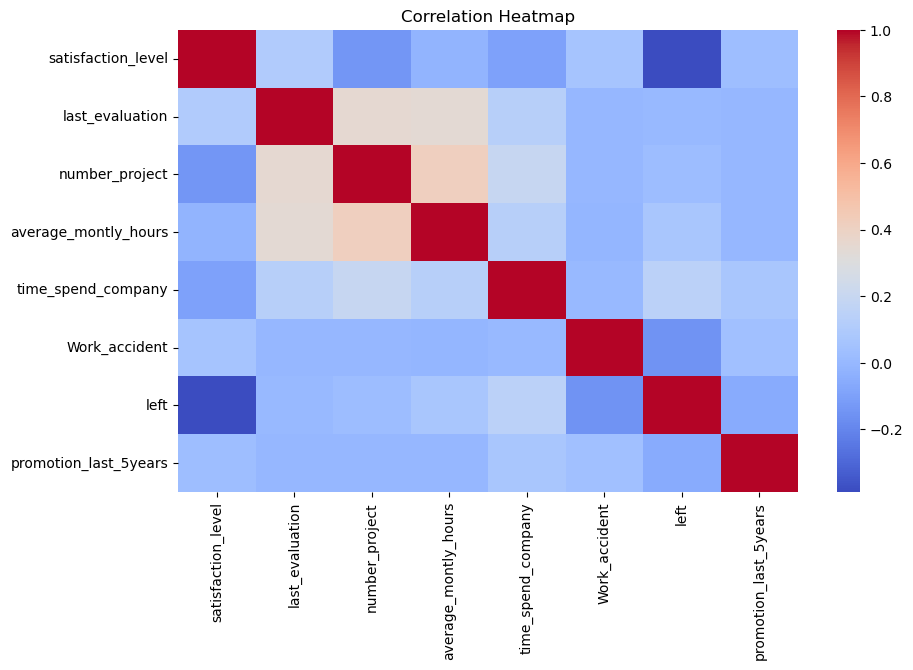

In [22]:
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=['int64','float64']).corr(), cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


Distributions

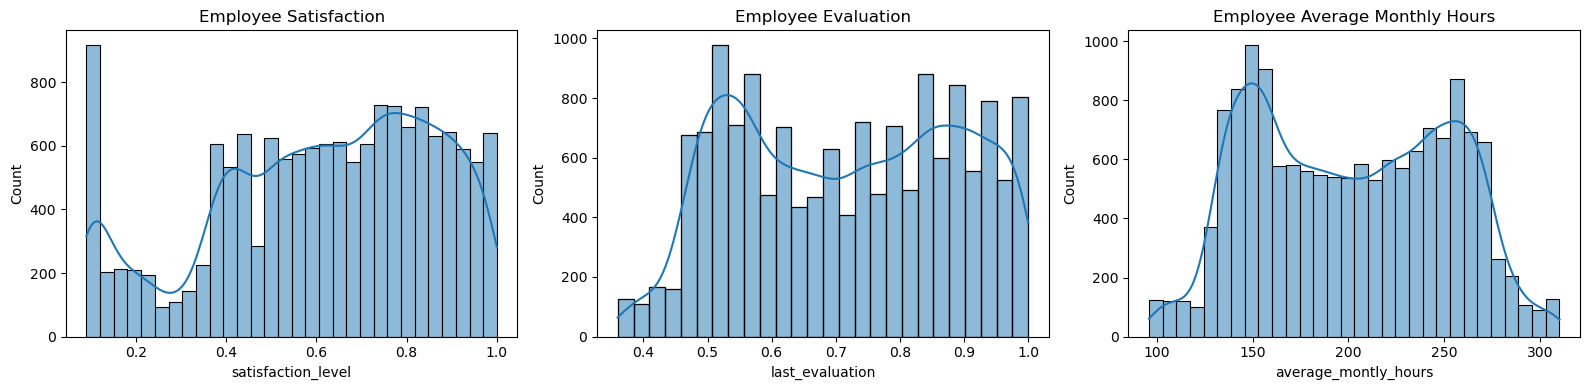

In [23]:
plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
sns.histplot(df['satisfaction_level'], kde=True)
plt.title("Employee Satisfaction")

plt.subplot(1,3,2)
sns.histplot(df['last_evaluation'], kde=True)
plt.title("Employee Evaluation")

plt.subplot(1,3,3)
sns.histplot(df['average_montly_hours'], kde=True)
plt.title("Employee Average Monthly Hours")

plt.tight_layout()
plt.show()


Project count vs left (bar plot)

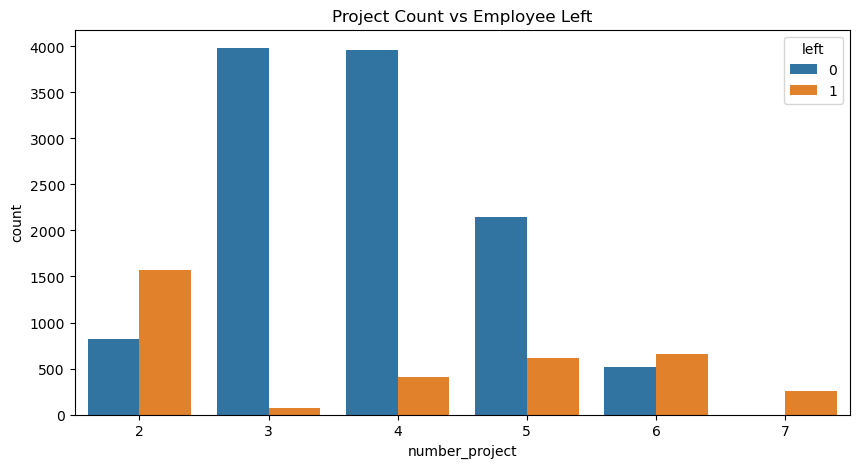

In [24]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='number_project', hue='left')
plt.title("Project Count vs Employee Left")
plt.show()


Selecting required columns → satisfaction, evaluation, left

In [25]:
df_left = df[df['left'] == 1][['satisfaction_level', 'last_evaluation']]
df_left.head()


,satisfaction_level,last_evaluation
0,0.38,0.53
1,0.80,0.86
2,0.11,0.88
3,0.72,0.87
4,0.37,0.52


Scale data & cluster into k=3

In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_left)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_left['cluster'] = clusters
df_left.head()


,satisfaction_level,last_evaluation,cluster
0,0.38,0.53,0
1,0.80,0.86,1
2,0.11,0.88,2
3,0.72,0.87,1
4,0.37,0.52,0


Visualize clusters

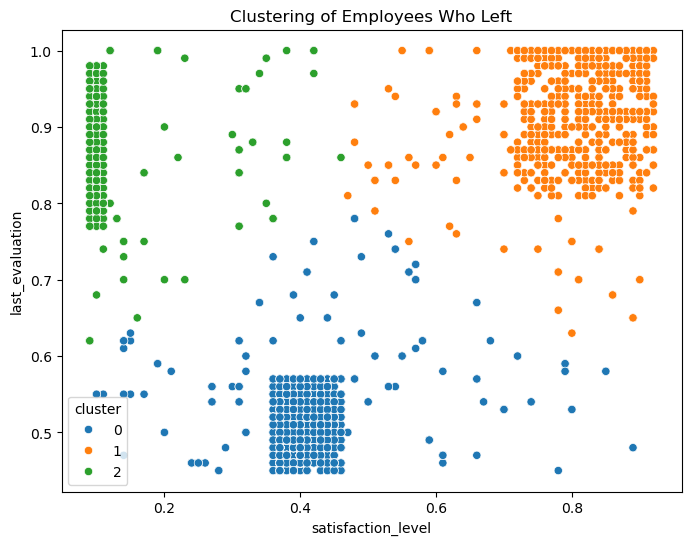

In [27]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_left, x='satisfaction_level', y='last_evaluation', hue='cluster', palette='tab10'
)
plt.title("Clustering of Employees Who Left")
plt.show()


Separate categorical & numeric columns

In [28]:
categorical = ['sales', 'salary']
numeric = df.drop(columns=categorical).columns.tolist()


Dummy encoding

In [29]:
df_cat = pd.get_dummies(df[categorical], drop_first=True)
df_num = df[numeric]

df_processed = pd.concat([df_num, df_cat], axis=1)
df_processed.head()


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,False,False,False,False,False,False,True,False,False,True,False
1,0.80,0.86,5,262,6,0,1,0,False,False,False,False,False,False,True,False,False,False,True
2,0.11,0.88,7,272,4,0,1,0,False,False,False,False,False,False,True,False,False,False,True
3,0.72,0.87,5,223,5,0,1,0,False,False,False,False,False,False,True,False,False,True,False
4,0.37,0.52,2,159,3,0,1,0,False,False,False,False,False,False,True,False,False,True,False


In [30]:
X = df_processed.drop('left', axis=1)
y = df_processed['left']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=123
)

print(X_train.shape, X_test.shape)


(11999, 18) (3000, 18)


In [31]:
smote = SMOTE(random_state=123)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

y_train.value_counts(), y_train_sm.value_counts()


(left
 0    9142
 1    2857
 Name: count, dtype: int64,
 left
 0    9142
 1    9142
 Name: count, dtype: int64)

Define helper function

In [32]:
def evaluate_model(model, X, y):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X, y, cv=kfold)
    print(classification_report(y, y_pred))
    return y_pred


In [33]:
print("Logistic Regression Performance:\n")

lr = LogisticRegression(max_iter=500)
lr_pred = evaluate_model(lr, X_train_sm, y_train_sm)


Logistic Regression Performance:

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      9142
           1       0.78      0.82      0.80      9142

    accuracy                           0.80     18284
   macro avg       0.80      0.80      0.80     18284
weighted avg       0.80      0.80      0.80     18284



In [34]:
print("Random Forest Performance:\n")

rf = RandomForestClassifier(random_state=42)
rf_pred = evaluate_model(rf, X_train_sm, y_train_sm)


Random Forest Performance:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9142
           1       0.99      0.97      0.98      9142

    accuracy                           0.98     18284
   macro avg       0.98      0.98      0.98     18284
weighted avg       0.98      0.98      0.98     18284



In [35]:
print("Gradient Boosting Performance:\n")

gb = GradientBoostingClassifier(random_state=42)
gb_pred = evaluate_model(gb, X_train_sm, y_train_sm)


Gradient Boosting Performance:

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      9142
           1       0.98      0.95      0.96      9142

    accuracy                           0.96     18284
   macro avg       0.96      0.96      0.96     18284
weighted avg       0.96      0.96      0.96     18284



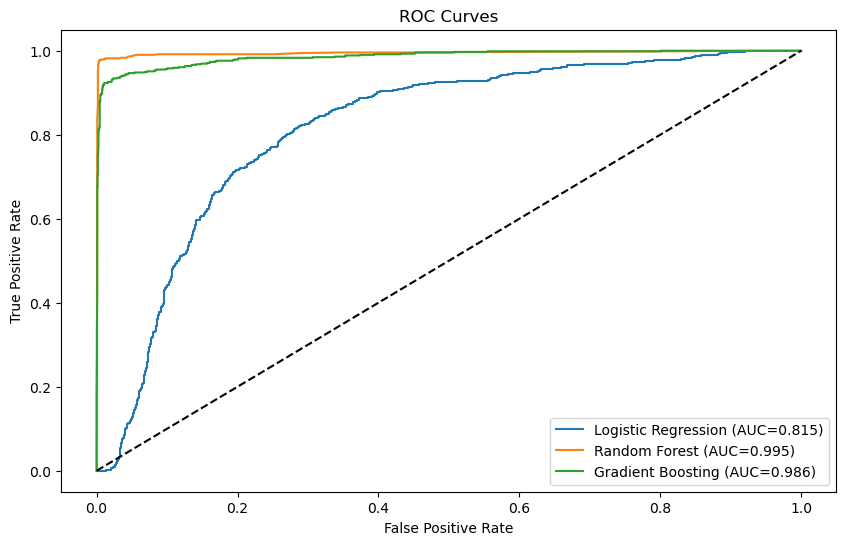

In [36]:
models = {
    "Logistic Regression": lr,
    "Random Forest": rf,
    "Gradient Boosting": gb
}

plt.figure(figsize=(10,6))

for name, model in models.items():
    model.fit(X_train_sm, y_train_sm)
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [37]:
for name, model in models.items():
    print(f"\n{name} Confusion Matrix:")
    model.fit(X_train_sm, y_train_sm)
    preds = model.predict(X_test)
    print(confusion_matrix(y_test, preds))



Logistic Regression Confusion Matrix:
[[1768  518]
 [ 184  530]]

Random Forest Confusion Matrix:
[[2270   16]
 [  15  699]]

Gradient Boosting Confusion Matrix:
[[2232   54]
 [  49  665]]


In [38]:
# Compute AUC for all
for name, model in models.items():
    model.fit(X_train_sm, y_train_sm)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    print(f"{name} AUC: {auc:.4f}")


Logistic Regression AUC: 0.8154
Random Forest AUC: 0.9947
Gradient Boosting AUC: 0.9857


Assume Gradient Boosting is best.

In [39]:
best_model = gb  # Replace if AUC shows another winner
best_model.fit(X_train_sm, y_train_sm)

proba = best_model.predict_proba(X_test)[:,1]


Categorize into zones

In [40]:
def categorize(p):
    if p < 0.20:
        return "Safe Zone (Green)"
    elif p < 0.60:
        return "Low Risk (Yellow)"
    elif p < 0.90:
        return "Medium Risk (Orange)"
    else:
        return "High Risk (Red)"

zones = [categorize(p) for p in proba]

zone_df = pd.DataFrame({
    "Probability": proba,
    "Risk_Zone": zones
})

zone_df.head()


,Probability,Risk_Zone
0,0.006049,Safe Zone (Green)
1,0.953911,High Risk (Red)
2,0.092437,Safe Zone (Green)
3,0.018467,Safe Zone (Green)
4,0.026336,Safe Zone (Green)
